In [1]:
import sys
from pathlib import Path

import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange

In [2]:
# Update path to import src code
sys.path.append("..")

In [3]:
from src import SplitNN, AttackModel, plot_images

In [4]:
project_root = Path.cwd().resolve().parent
im_save_path = project_root / "results"

In [5]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

---
# 1. Investigate NoPeek
Here we shall run a black box model inversion on a NoPeekNN
to demonstrate that data has been protected.

## Load target model
Load a model trained without noise

In [6]:
target_model_path = project_root / "models" / (f"nopeek_01weight.pth")

In [7]:
target_model = SplitNN()

checkpoint = torch.load(target_model_path)
target_model.load_state_dict(checkpoint["model_state_dict"])

target_model = target_model.to(device)
target_model.eval()
target_model

SplitNN(
  (encode): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=9216, out_features=500, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

## Confirm target model performance

In [8]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

In [9]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[:5_000]
mnist_test.targets = mnist_test.targets[:5_000]

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000)

In [10]:
target_test_correct = 0
target_test_total = 0

for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = target_model(data)

    target_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    target_test_total += outputs.size(0)

target_test_accuracy = 100 * target_test_correct / target_test_total
print(f"Target model accuracy: {target_test_accuracy:.3f}")

Target model accuracy: 95.220


It's not great by MNIST standards, but is good enough for demonstration purposes.

## Train attacker
We will train the attack model on EMNIST images.
These are similar enough to MNIST for the attack to work in principle,
but different enough to simulate a real-world attack setting (unknown training data).

In [11]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 500]
emnist_train.targets = emnist_train.targets[: 500]

emnist_loader = torch.utils.data.DataLoader(emnist_train, batch_size=128)

In [12]:
attack_model = AttackModel().to(device)
attack_model.train()
attack_optim = torch.optim.Adam(attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader:
        attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            intermediate_data = target_model.encode(data)
            

        reconstructed_data = attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.77s/it]


## Visualise reconstruction

In [13]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[5_000:]
mnist_test.targets = mnist_test.targets[5_000:]

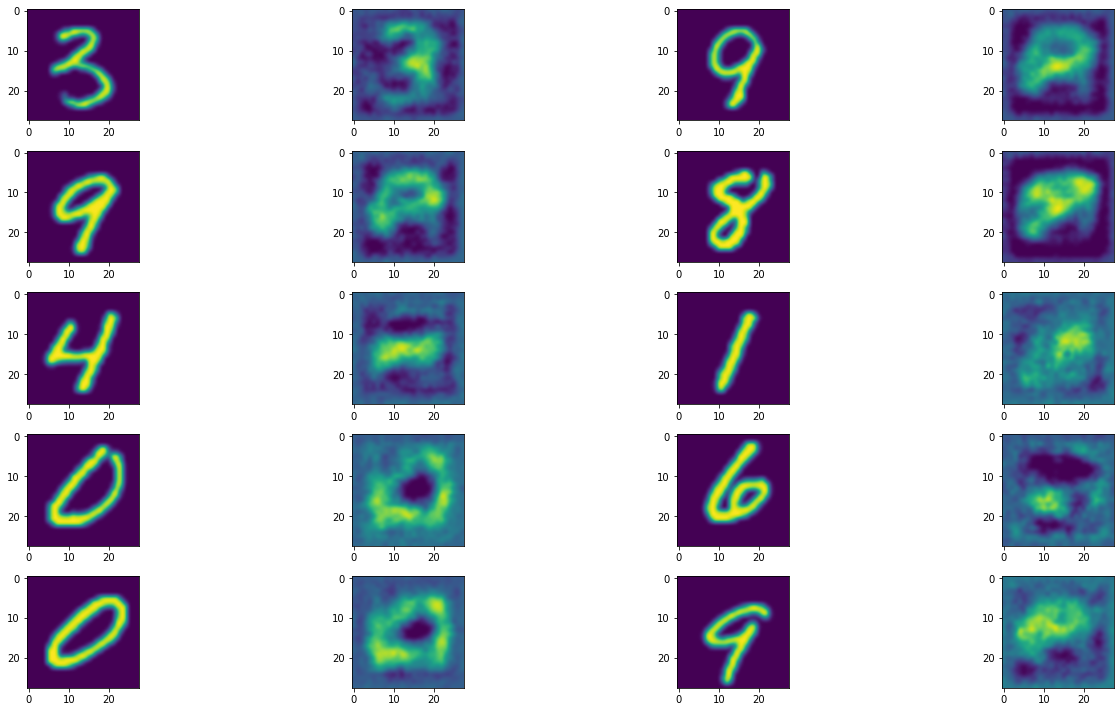

In [14]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, save_path=im_save_path / "reconstruction_01weight_500ims.png")

As you can see, NoPeekNN has stopped the attacker from learning how to reconstruct _some_ of the intermediate data. But what happens if the attacker has access to more data?

In [18]:
emnist_train_large = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train_large.data = emnist_train_large.data[: 5000]
emnist_train_large.targets = emnist_train_large.targets[: 5000]

emnist_loader_large = torch.utils.data.DataLoader(emnist_train_large, batch_size=128)

In [19]:
attack_model_large = AttackModel().to(device)
attack_model_large.train()
attack_optim = torch.optim.Adam(attack_model_large.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader_large:
        attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            intermediate_data = target_model.encode(data)
            

        reconstructed_data = attack_model_large(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.62s/it]


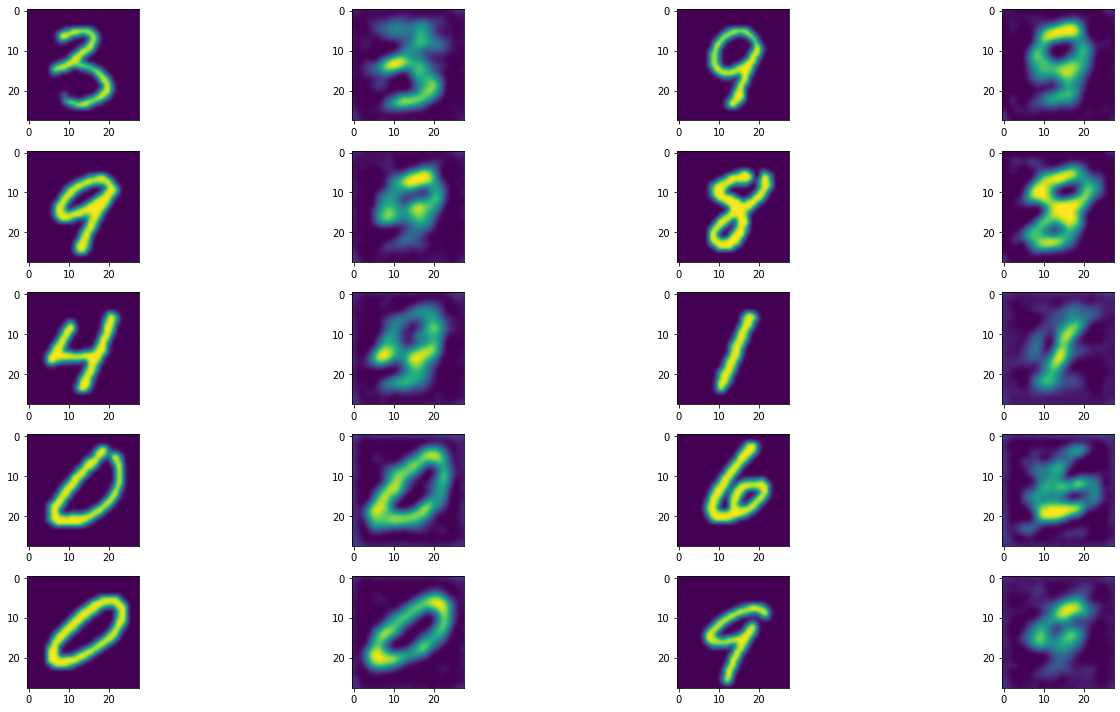

In [20]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model_large(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, save_path=im_save_path / "reconstruction_01weight_5000ims.png")

NoPeekNN is not sufficient in this case (with a `0.1` weighting). Is 5000 training data realistic? If a computational server colluded with a data holder, in practice the attackers would have access to more than 5'000 training images and the intermediate outputs necessary to develop a strong attacker.

While NoPeekNN _can_ work to defend against a model inversion attack, there are mathematical guarantees of this.